In [22]:
import glam
import pandas as pd
import numpy as np
import os.path
import seaborn as sns

import matplotlib.pyplot as plt

In [23]:
import pymc3 as pm

In [24]:
np.random.seed(23) # from random.org

In [25]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

# Individual GLAM estimation and out of sample prediction (More)

## Load data

In [26]:
# Load data
sufix = '_individual_More_NoBin_excludedTrial_Gamma-11_NUTS_32'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_More_NoBin_33_v2.csv')

## Reaction times for each participant

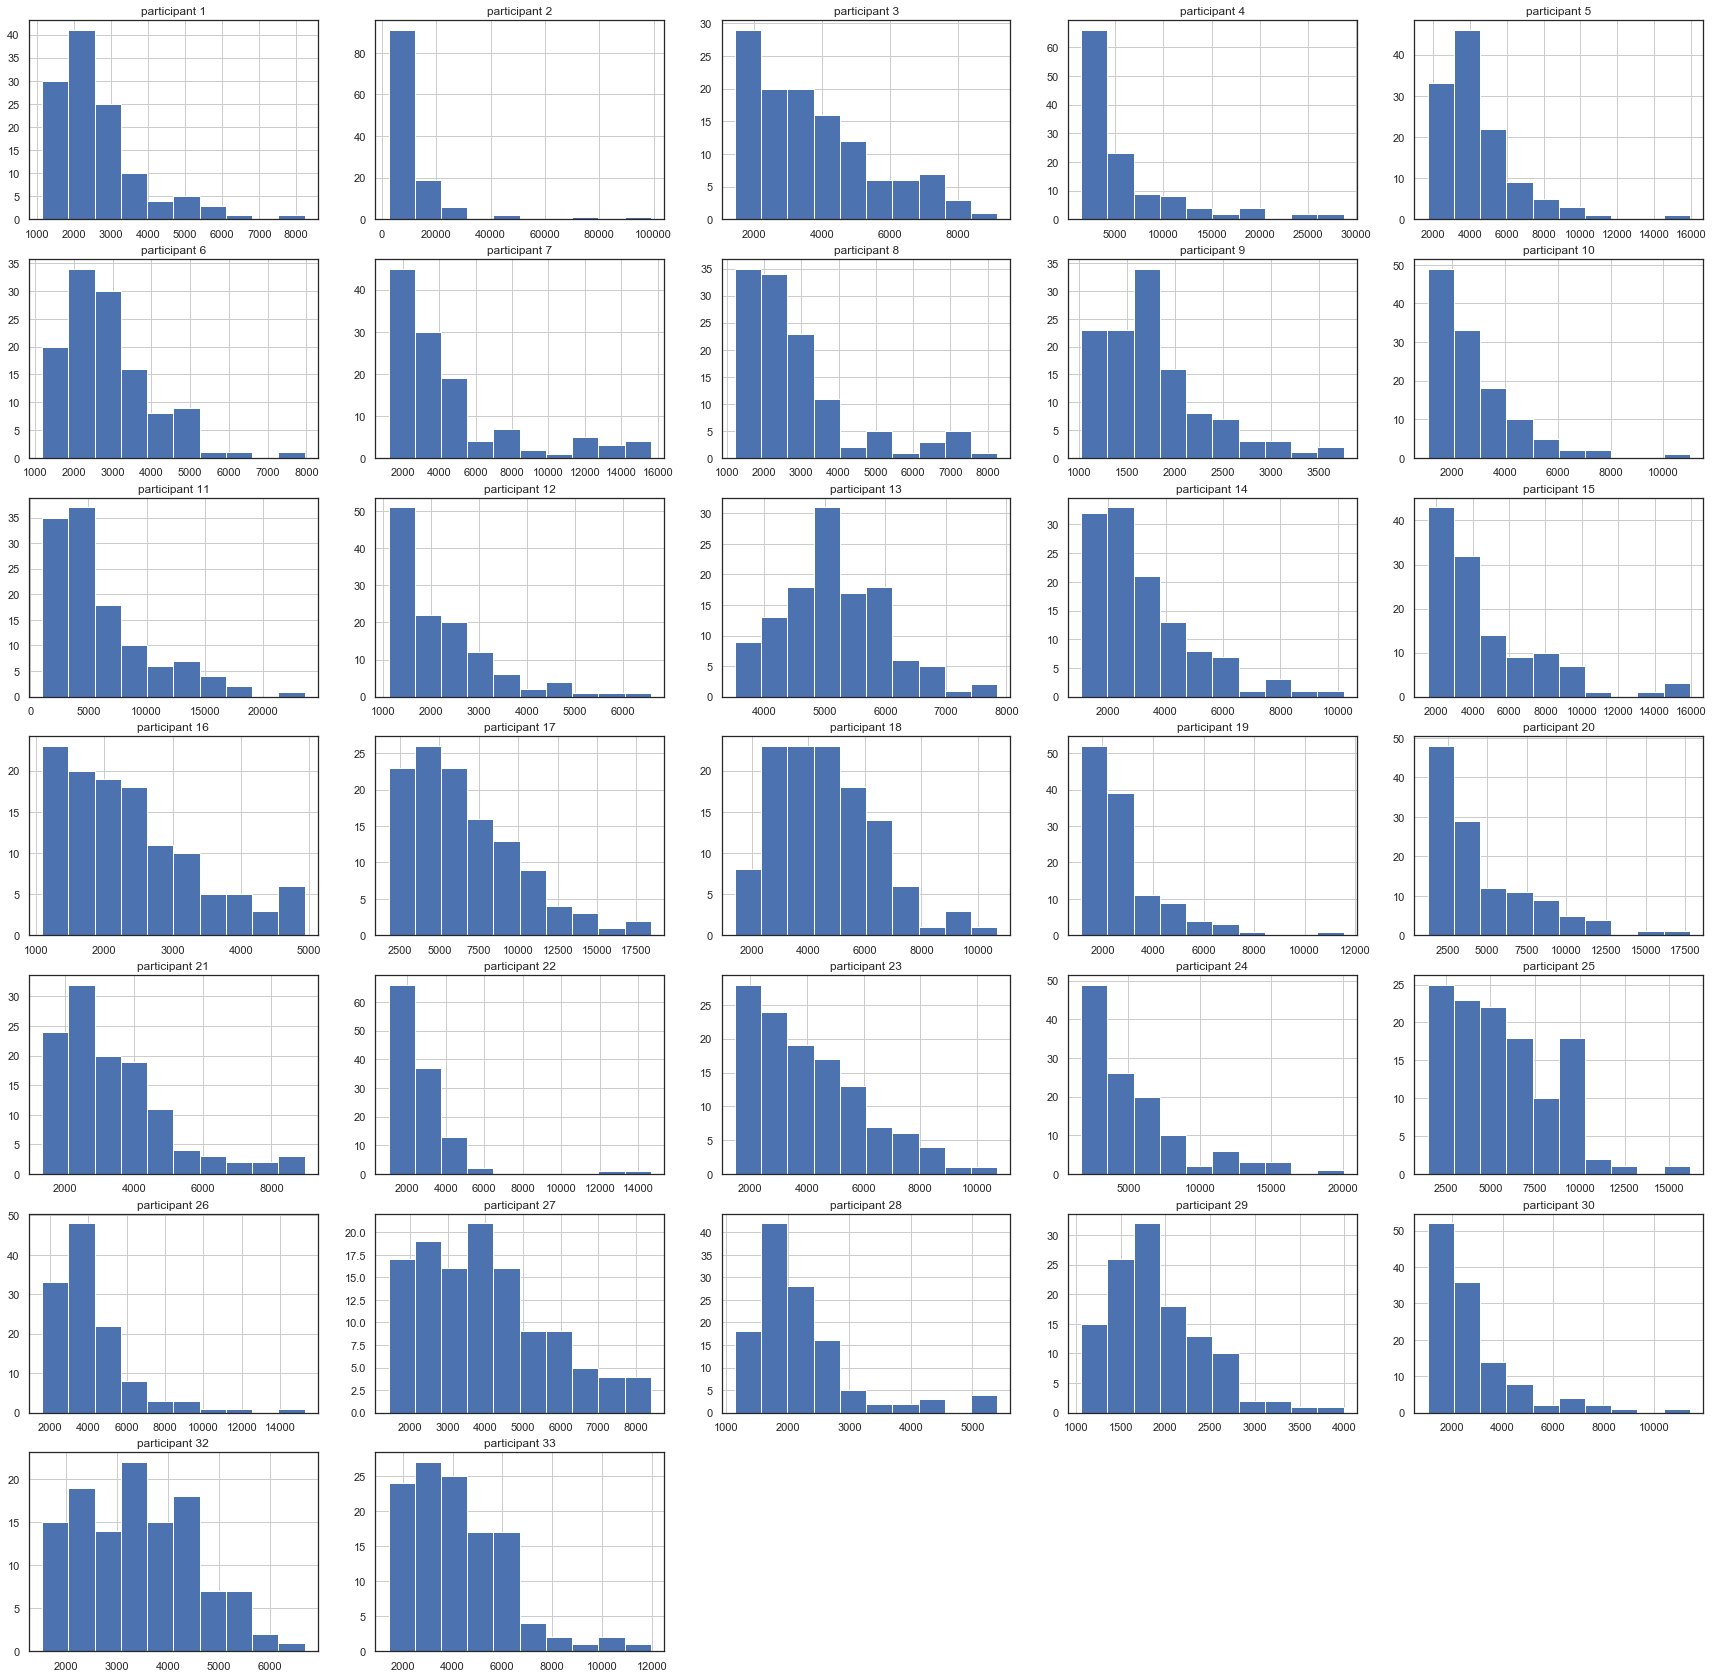

In [27]:
participants = data.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data[(data.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1


In [28]:
data["zrt"] = z_score1(data,'subject',"rt")

## Remove outliers

In [29]:
# remove outliers (two criteria)
data1 = data[(data.zrt <= 3) ]
data1 = data1[(data1.rt <= 20000) ]

In [30]:
#participants = data.subject.unique()
#f = plt.figure(figsize=(30,30))
#order = 1
#sns.set_style('white')

#for i in data.subject.unique():
#    sub={}
#    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
#    sub['%s' % i].plot()    
#    data[(data.subject == i)].zrt.hist()
#    sub['%s' % i].set_title('participant %s' % i)
#    order += 1

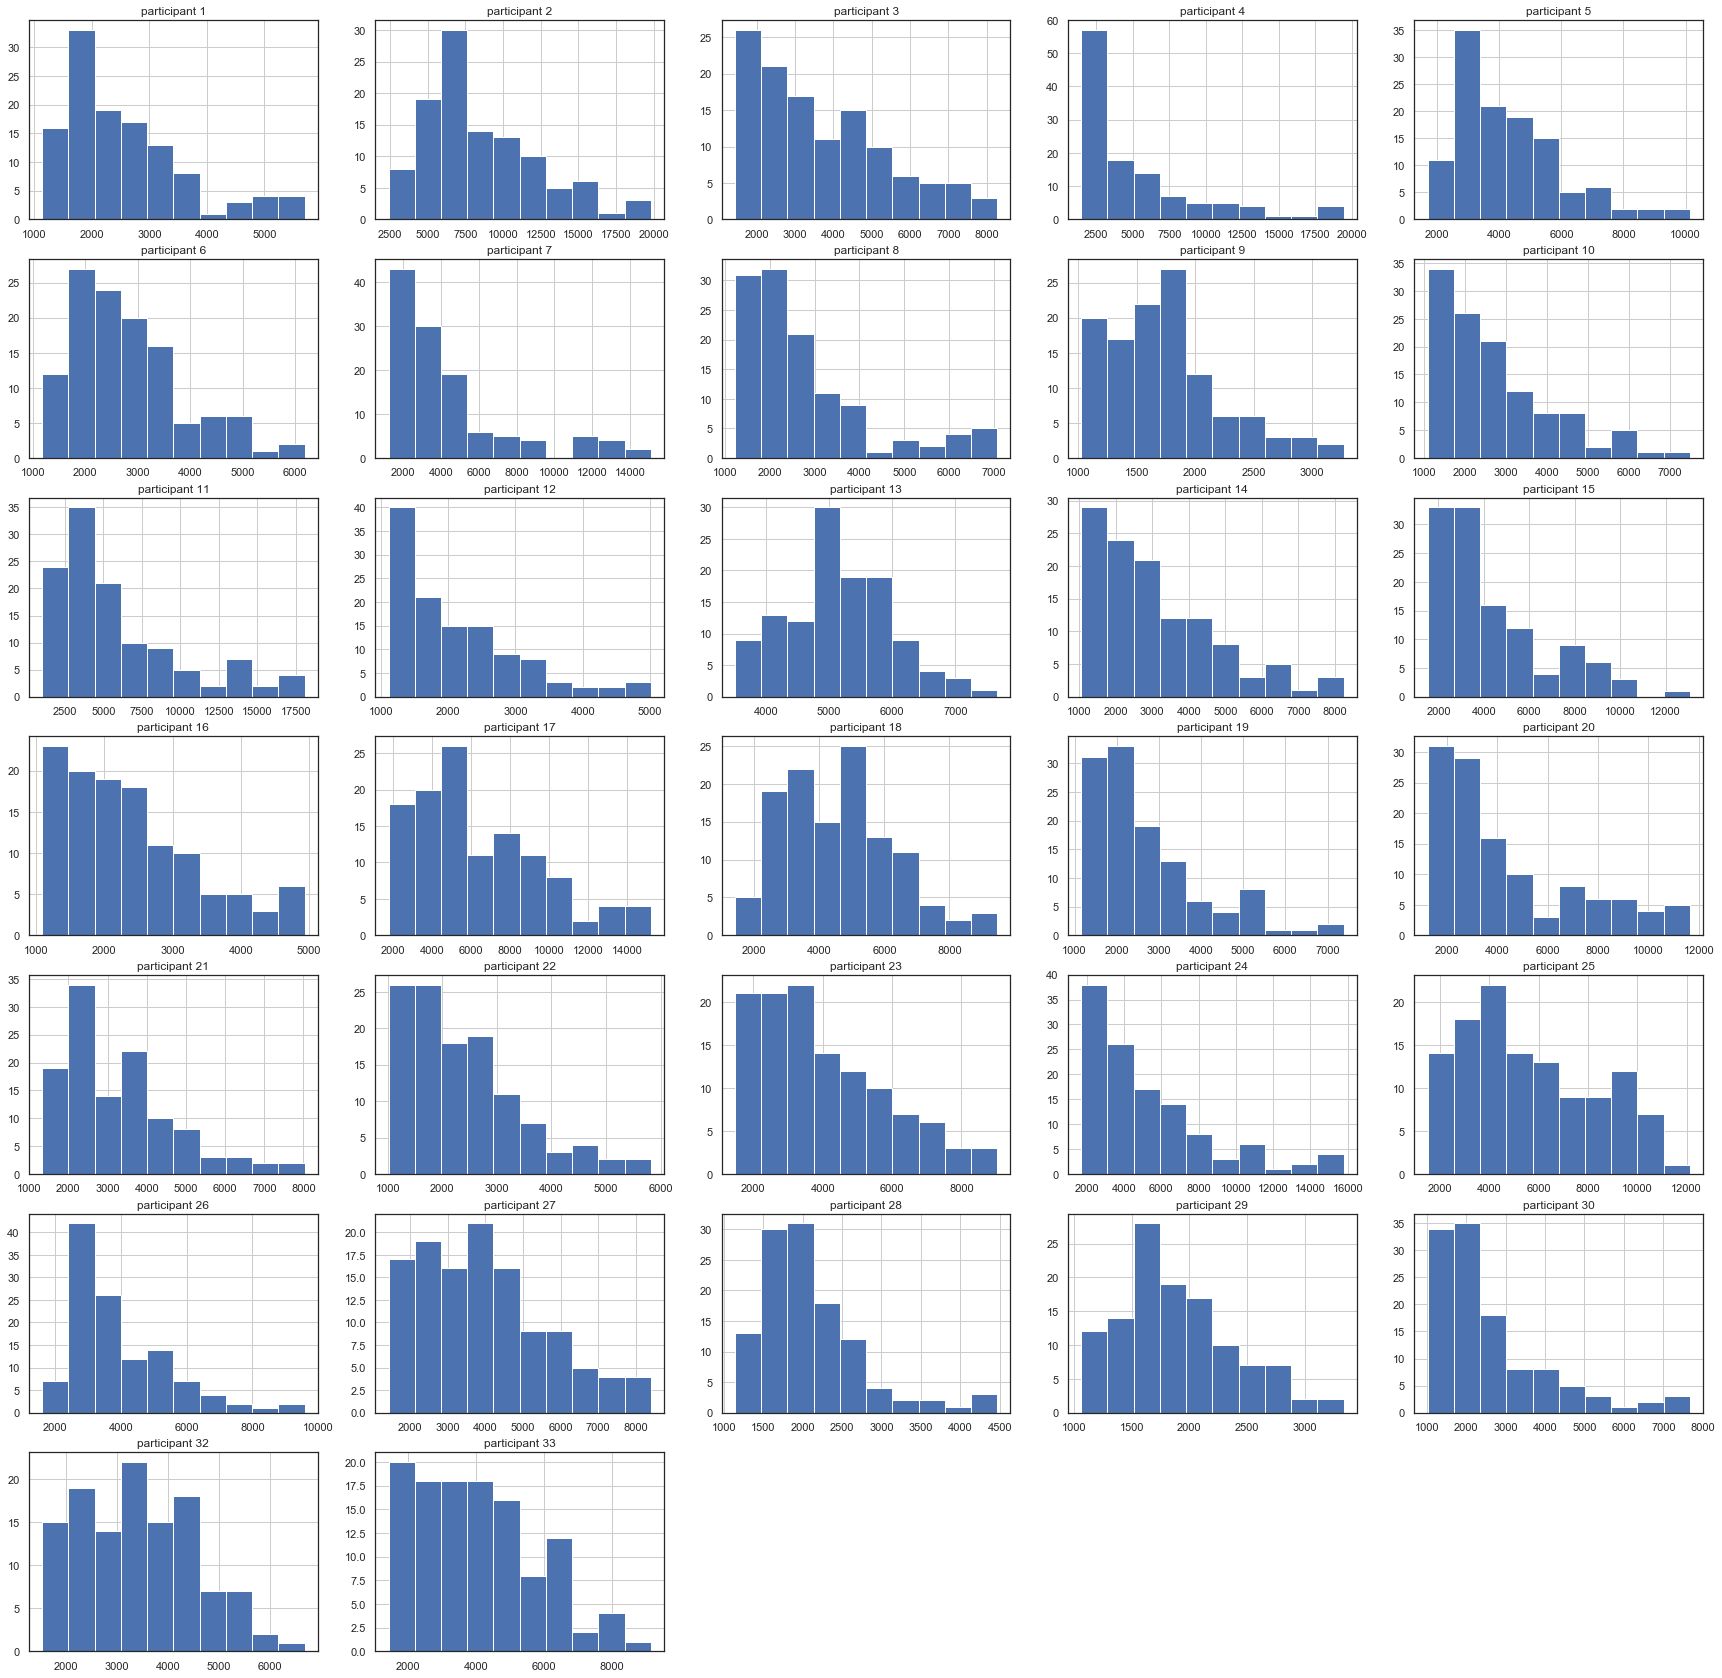

In [31]:
participants = data1.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data1.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data1[(data1.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1

# Subset only necessary columns

In [32]:
data = data1[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,1,1734.284,110,131,0.669090,0.330910
2,1,2,0,3174.566,50,44,0.549371,0.450629
3,1,3,1,2877.579,57,50,0.608409,0.391591
4,1,4,1,1806.310,42,50,0.522849,0.477151
5,1,5,0,3636.816,108,110,0.559774,0.440226


## Split data in training and test sets

In [33]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1894 trials) and test (1879 trials) sets...


## Individual GLAM estimation

### 1. full GLAM

In [34]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_full'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))   

Fitting full GLAM individually...
Generating single subject models for 32 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 32 model(s) using NUTS...
  Fitting model 1 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1634.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1111.74draws/s]
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5984038599435744, but should be close to 0.8. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1326.36draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1019.55draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1483.50draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1276.90draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48610747330392284, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 7 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 819.48draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1198.12draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1329.22draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1205.31draws/s]
The acceptance probability does not match the target. It is 0.7032102486980795, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 977.01draws/s]
There were 651 divergences after tuning. Increase `target_accept` or reparameterize.
There were 611 divergences after tuning. Increase `target_accept` or reparameterize.
There were 612 divergences after tuning. Increase `target_accept` or reparameterize.
There were 665 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:54<00:00, 221.50draws/s]
The acceptance probability does not match the target. It is 0.6956678912365533, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 13 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1084.95draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 14 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1698.88draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 15 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1066.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 16 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:29<00:00, 409.36draws/s]
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.583635914751719, but should be close to 0.8. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 17 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1198.77draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 18 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1283.33draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5267887880862447, but should be close to 0.8. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 19 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1050.15draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 20 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 864.71draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 21 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1336.24draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 22 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1191.14draws/s]
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 23 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1130.67draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 24 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1031.01draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 25 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1323.01draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 26 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1247.19draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8919621095032457, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 27 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1305.15draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9048225253716458, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8869726130255722, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 28 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:41<00:00,  4.81draws/s]
The acceptance probability does not match the target. It is 0.7097523046449068, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7056434769369758, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6948999446020339, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.720836602458

  Fitting model 29 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:44<00:00, 269.04draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8921643771101431, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 30 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1077.68draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7042897604508854, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 31 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1291.83draws/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 32 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 924.74draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/!\ Automatically setting parameter precision...


In [35]:
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_full'+sufix+'.npy'), glam_full.estimates)

In [36]:
pd.DataFrame.from_dict(glam_full.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,198.29,1.0,0.80,0.05,0.009338,[0.0],1.80,0.000041
1,367.84,1.0,0.88,0.05,0.004970,[0.0],0.29,0.000012
2,210.70,1.0,0.45,0.05,0.007683,[0.0],0.13,0.000030
3,370.45,1.0,0.94,0.05,0.009844,[0.0],0.26,0.000024
4,156.19,1.0,0.76,0.05,0.005216,[0.0],0.12,0.000034
5,119.54,1.0,0.69,0.05,0.007503,[0.0],0.09,0.000046
6,419.20,1.0,0.87,0.05,0.010721,[0.0],0.14,0.000025
7,166.28,1.0,-0.95,0.05,0.007235,[0.0],0.30,0.000044
8,78.09,1.0,0.99,0.05,0.006916,[0.0],0.02,0.000095
9,161.82,1.0,-0.25,0.05,0.008795,[0.0],0.27,0.000042


In [37]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_PF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_PF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_PF2019_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...
  Found old DIC scores in "results/waic". Skipping WAIC computation...


In [38]:
glam_full.waic

array([[1.02299743e+03, 0.00000000e+00, 1.54512423e+00, 1.00000000e+00],
       [1.08954604e+03, 0.00000000e+00, 1.66725873e+00, 1.00000000e+00],
       [1.09682866e+03, 0.00000000e+00, 2.68050129e+00, 1.00000000e+00],
       [1.12859093e+03, 0.00000000e+00, 1.52157763e+00, 1.00000000e+00],
       [1.07738595e+03, 0.00000000e+00, 2.23569222e+00, 1.00000000e+00],
       [1.06235648e+03, 0.00000000e+00, 5.05252698e+00, 1.00000000e+00],
       [1.13925103e+03, 0.00000000e+00, 1.67131031e+00, 1.00000000e+00],
       [1.02405290e+03, 0.00000000e+00, 4.04586609e+00, 1.00000000e+00],
       [9.62541039e+02, 0.00000000e+00, 2.55160680e+00, 1.00000000e+00],
       [1.01206320e+03, 0.00000000e+00, 2.86642894e+00, 1.00000000e+00],
       [1.19437413e+03, 0.00000000e+00, 2.01304589e+00, 1.00000000e+00],
       [9.55882250e+02, 0.00000000e+00, 2.32308485e+00, 1.00000000e+00],
       [1.05338627e+03, 0.00000000e+00, 1.73898476e+00, 1.00000000e+00],
       [1.04719291e+03, 0.00000000e+00, 2.62332766e

In [39]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_full'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1894 trials) with new data (1879 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,0.0,0.0,2747.0,50,0.549371,44,0.450629
1,1.0,0.0,1.0,0.0,1771.0,50,0.549371,44,0.450629
2,1.0,0.0,2.0,0.0,1045.0,50,0.549371,44,0.450629
3,1.0,0.0,3.0,0.0,2949.0,50,0.549371,44,0.450629
4,1.0,0.0,4.0,0.0,1924.0,50,0.549371,44,0.450629


### 1. no-bias GLAM

In [40]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM individually...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy'))
 

Fitting no-bias GLAM individually...
Generating hierarchical model for 32 subjects...


/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


IndexError: index 32 is out of bounds for axis 0 with size 32

In [ ]:
   
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

In [ ]:
# In case it is already fitted
params_part_like = pd.DataFrame.from_dict(glam_nobias.estimates.item(0))
params_part_like

In [ ]:
# Compute LOO

glam_nobias.loo = pm.loo(trace=glam_nobias.trace, model=glam_nobias.model)
glam_nobias.loo

np.save(str('results/loo/glam_PF2019_nobias'+ sufix +'.npy'), glam_nobias.loo
)

In [ ]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv'))

glam_nobias.prediction.head()

## 2. Plot fit

In [ ]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

plt.show()

## Parameters for full hierarchical model

In [ ]:
params_participant = glam_full.estimates
params_participant

In [ ]:
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

In [ ]:
params_participant

In [ ]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

In [ ]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 